# SEIR Model for COVID-19 Forecasting

In [1]:
%load_ext lab_black

# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from bayes_opt import BayesianOptimization
from scipy.optimize import minimize, least_squares
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

# Other
import copy
from datetime import datetime, timedelta
import os
import random
import sys
from typing import List, Tuple

# Custom module
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join("../ygg_seir_simulator/"))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.plotting import plot_predictions
from src.utils import get_covid_data, get_all_covid_data
from ygg_seir_simulator.fixed_params import *
from ygg_seir_simulator.region_model import RegionModel
from ygg_seir_simulator.learn_simulation import *
from ygg_seir_simulator.simulation import run, predict
from ygg_seir_simulator.util import str_to_date, remove_space_region

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## Purpose

The goal is to produce accurate forecasts of COVID-19 deaths and infections in Canada. One of the models we'll be focusing on is an SEIR model using a simulator based off of https://covid19-projections.com/model-details/.  

## Load Data

For the data we'll only be using mortality data as data on active infections and new infections can be innacurate and add noise to the model. The dataset can be found here https://github.com/ishaberry/Covid19Canada.

In [2]:
# Read in data
mortality_start_date = datetime.date(day=8, month=3, year=2020)
mortality_provinces = get_all_covid_data(level="prov").query(
    "date >= @mortality_start_date"
)

provinces = ["Alberta", "BC", "Manitoba", "Ontario", "Quebec", "Saskatchewan"]

# Get first and last day of death reports
mortality_start_date = mortality_provinces["date"].min()
mortality_end_date = mortality_provinces["date"].max()

# Filter for Ontario
mortality_ontario = mortality_provinces.query('province == "Ontario"')

mortality_provinces.head(10)

,province,date,cumulative_cases,cumulative_recovered,cumulative_deaths,active_cases,active_cases_change,deaths,recovered,cases,population,removed,cumulative_removed,susceptible,percent_susceptible
43,Alberta,2020-03-08,4,0,0,4,2,0,0,2,4421876,0,0,4421872,0.999999
44,Alberta,2020-03-09,14,0,0,14,10,0,0,10,4421876,0,0,4421862,0.999997
45,Alberta,2020-03-10,14,0,0,14,0,0,0,0,4421876,0,0,4421862,0.999997
46,Alberta,2020-03-11,19,0,0,19,5,0,0,5,4421876,0,0,4421857,0.999996
47,Alberta,2020-03-12,23,0,0,23,4,0,0,4,4421876,0,0,4421853,0.999995
48,Alberta,2020-03-13,29,0,0,29,6,0,0,6,4421876,0,0,4421847,0.999993
49,Alberta,2020-03-14,39,0,0,39,10,0,0,10,4421876,0,0,4421837,0.999991
50,Alberta,2020-03-15,56,0,0,56,17,0,0,17,4421876,0,0,4421820,0.999987
51,Alberta,2020-03-16,74,0,0,74,18,0,0,18,4421876,0,0,4421802,0.999983
52,Alberta,2020-03-17,97,0,0,97,23,0,0,23,4421876,0,0,4421779,0.999978


## SEIR Parameter Estimation

First we would want to replace the simple grid search layer in the original model with more sophisticated optimization methods. We will be fine tuning the current model and so the only parameters we'll be tuning are:

- Mortality rate
- Initial $R_0$
- Lockdown $R_0$
- Imports of positive cases per day

To handle overfitting we'll be applying cross-validation. Since we are dealing with time series we will split our data a bit differently. The data will be split into folds in order from 1 to k and for each $i$ from 1 to k we will use train the model on the first 1 to i folds and validate on the remaining folds. For our loss function we'll be using root mean squared error (RMSE) on the cumulative sum of deaths and not use any of the data on cases/recovered since those reports can be innacurate and add noise to the model.

In each of the following estimation methods we'll be using Ontario data to give an example of the algorithm

In [3]:
# Set argument values
skip_hospitalizations = None
quarantine_perc = 0
quarantine_effectiveness = -1
best_params_type = "mean"
country = "Canada"
region = "ALL"
subregion = "Ontario"
best_params_dir = "../models/best_params/latest"

# Set start and end dates
simulation_start_date = mortality_start_date - timedelta(days=DAYS_BEFORE_DEATH)
simulation_create_date = datetime.date(year=2020, month=10, day=1)
simulation_end_date = mortality_provinces["date"].max() + timedelta(days=40)

# Load parameters from file. This contains both fixed and variable parameters. We will not use the given variable parameters however
region_param, params_dict = load_best_params_province(best_params_dir, "Ontario")
for variable_param in [
    "INITIAL_R_0",
    "LOCKDOWN_R_0",
    "MORTALITY_RATE",
    "DAILY_IMPORTS",
]:
    val = params_dict.pop(variable_param)

# Create base region models for each province
province_populations = (
    mortality_provinces[["province", "population"]]
    .drop_duplicates()
    .set_index("province")
    .T.to_dict("list")
)
region_models = {}

for province in provinces:
    region_models[province] = RegionModel(
        country_str=country,
        region_str=region,
        subregion_str=province,
        first_date=simulation_start_date,
        projection_create_date=simulation_create_date,
        projection_end_date=simulation_end_date,
        region_params={"population": province_populations[province][0]},
        compute_hospitalizations=(not skip_hospitalizations),
    )

# Dataframe to store cross validation scores
cv_scores = pd.DataFrame(columns=["province", "method", "fold", "rmse"])

Loading params file: ../models/best_params/latest/subregion\Canada_Ontario.json


In [4]:
def loss(
    variable_params: Tuple,
    params: dict,
    region_model: RegionModel,
    mortality_data: pd.DataFrame,
) -> float:
    """
    Helper function for calculting root mean squared error for SEIR model.
    The variable params should be (initial_r_0, lockdown_r_0, mortality_rate, daily_imports)
    """
    # Initialize parameters for region model
    (
        params["INITIAL_R_0"],
        params["LOCKDOWN_R_0"],
        params["MORTALITY_RATE"],
        params["DAILY_IMPORTS"],
    ) = variable_params
    params_tups = tuple(params.items())
    region_model_copy = copy.deepcopy(region_model)
    region_model_copy.init_params(params_tups)

    # Run SEIR simulation
    mortality_pred = predict(region_model_copy, mortality_data)

    # Calculate rmse. Use only projections for known dates and not future forecasts
    mortality_pred = mortality_pred.query("cumulative_deaths == cumulative_deaths")
    deaths_true = mortality_pred["cumulative_deaths"]
    deaths_pred = mortality_pred["cumulative_deaths_pred"]

    rmse = np.sqrt(np.mean((deaths_true - deaths_pred) ** 2))

    return rmse

### L-BFGS-B Optimization

Bound constrained minimization implemented in scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [5]:
%%time

# Estimate optimal parameters using L-BFGS-B method in scipy
x0 = [1, 1, 0.01, 100]
bounds = [(1e-4, 10), (1e-4, 10), (1e-4, 0.2 - 1e-6), (0, 1000)]

optimal = minimize(
    loss,
    x0=x0,
    args=(params_dict.copy(), region_models['Ontario'], mortality_ontario),
    method="L-BFGS-B",
    bounds=bounds,
)

Wall time: 6.04 s


In [6]:
# Initialize parameters for region_model using estimated params
params = params_dict.copy()
(
    params["INITIAL_R_0"],
    params["LOCKDOWN_R_0"],
    params["MORTALITY_RATE"],
    params["DAILY_IMPORTS"],
) = optimal.x
params_tups = tuple(params.items())
region_models["Ontario"].init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_models["Ontario"], mortality_ontario)
rmse = loss(optimal.x, params_dict.copy(), region_models["Ontario"], mortality_ontario)
print(f"rmse: {rmse}\n")

rmse: 137.59297028244688



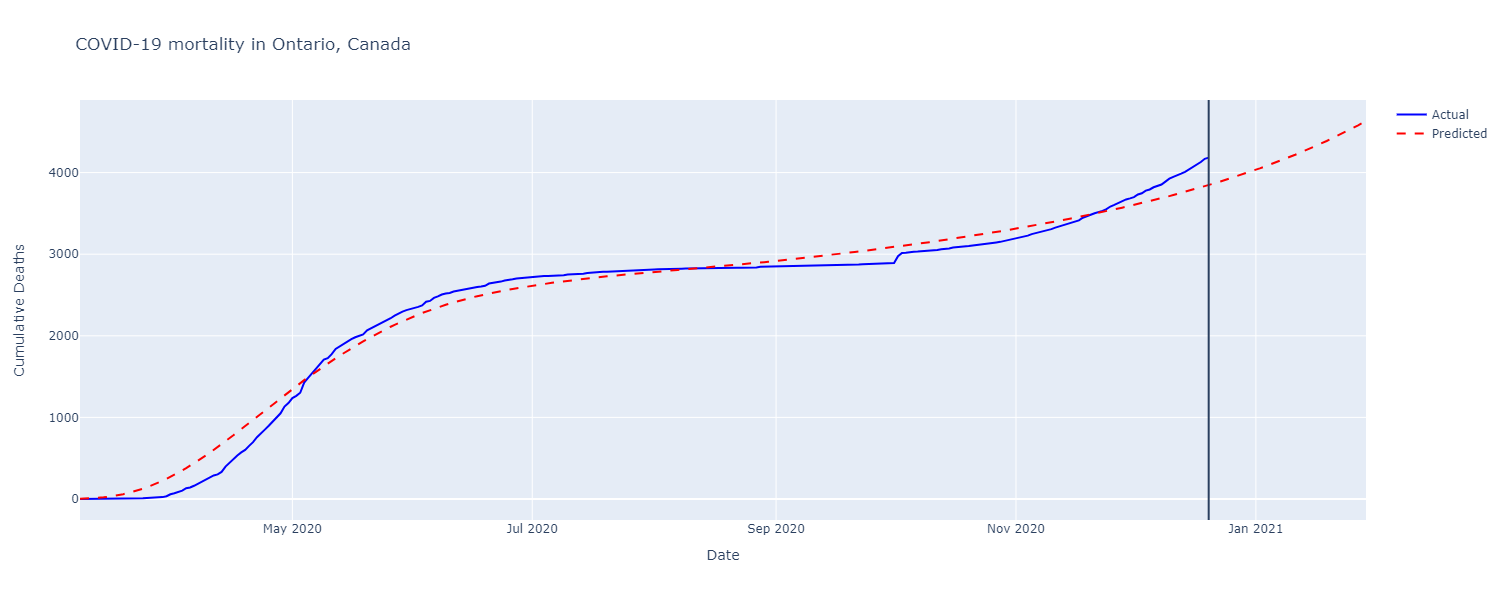

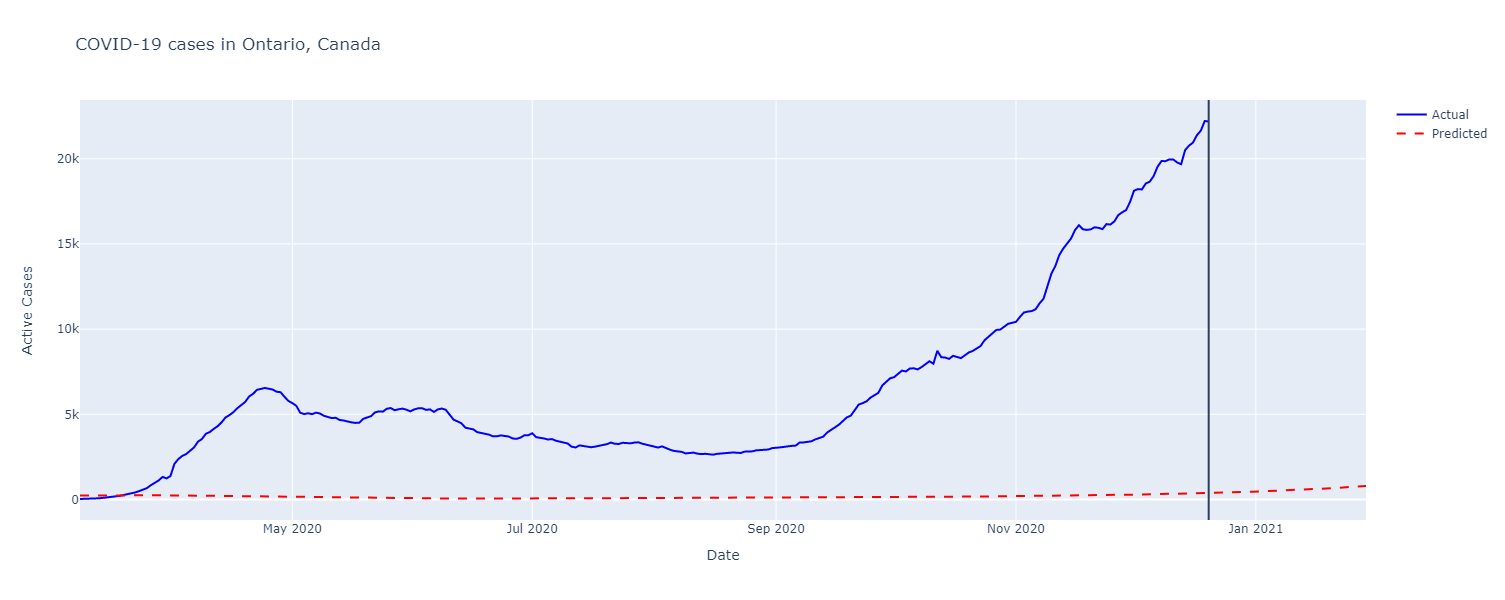

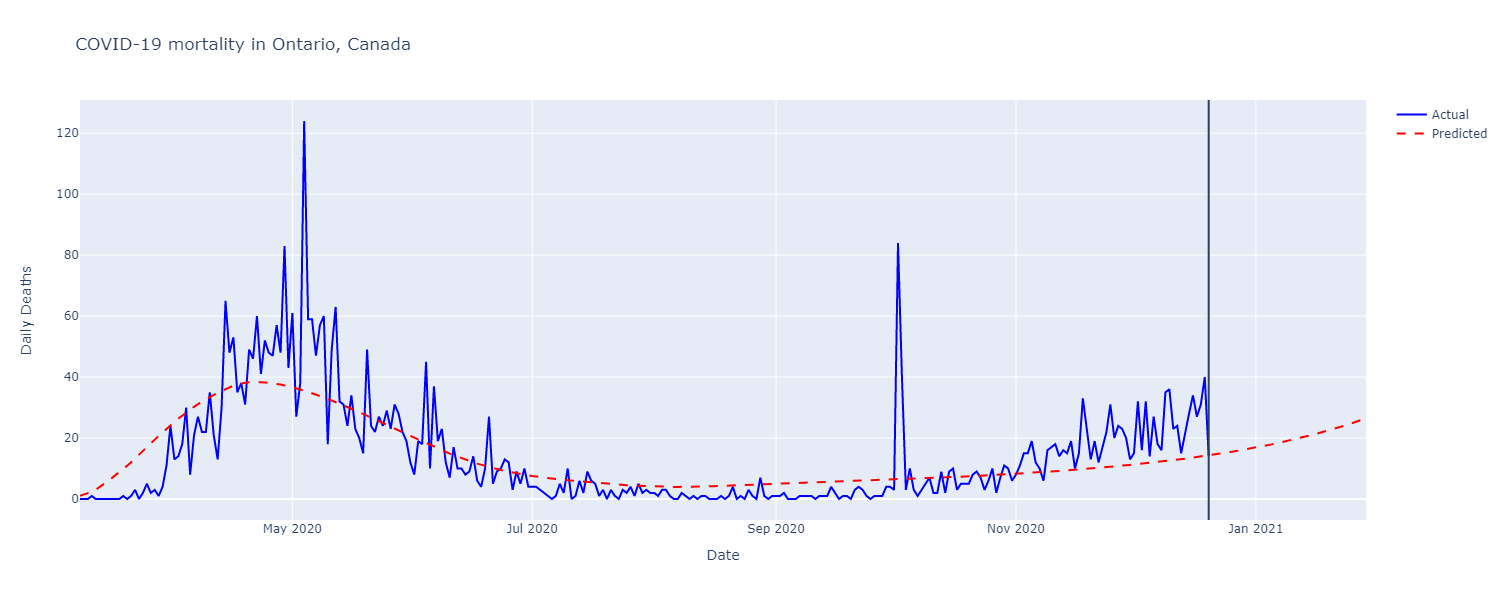

In [11]:
# Plot results for cumulative deaths
plot_predictions(
    mortality_pred,
    y="cumulative_deaths",
    y_label="Cumulative Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

# Plot results for daily deaths
plot_predictions(
    mortality_pred,
    y="deaths",
    y_label="Daily Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

#### Cross validation scores

In [8]:
%%time

tscv = TimeSeriesSplit(n_splits=10)

# loop through each province and each split
for province in provinces:
    mortality_province = mortality_provinces.query('province == @province')
    region_model = region_models[province]
    
    for index, (train_index, test_index) in enumerate(tscv.split(mortality_province)):
        mortality_train = mortality_province.iloc[train_index]
        mortality_test = mortality_province.iloc[test_index]

        # Fit model to train set
        optimal = minimize(
            loss,
            x0=x0,
            args=(params_dict.copy(), region_model, mortality_train),
            method="L-BFGS-B",
            bounds=bounds,
        )
        
        # Initialize parameters
        params = params_dict.copy()
        (
            params["INITIAL_R_0"],
            params["LOCKDOWN_R_0"],
            params["MORTALITY_RATE"],
            params["DAILY_IMPORTS"],
        ) = optimal.x
        params_tups = tuple(params.items())
        region_model.init_params(params_tups)

        # Run simulation and calculate loss
        mortality_pred = predict(region_model, mortality_train)
        mortality_pred = mortality_pred.iloc[test_index]

        rmse = mean_squared_error(mortality_test['cumulative_deaths'], mortality_pred['cumulative_deaths_pred'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'l-bfgs-b', 'fold': index, 'rmse': rmse}, ignore_index=True)
        
        
# Save results
cv_scores.to_csv("../models/seir_cross_val_scores.csv", index=False)

Wall time: 11min 29s


In [9]:
# Average rmse scores
cv_scores.groupby(["province", "method"]).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province    method        rmse                                    
                                 mean         std        min          max
0       Alberta  l-bfgs-b   67.068382   74.641694   3.095179   231.712604
1            BC  l-bfgs-b   42.972625   68.347878   4.009186   232.534123
2      Manitoba  l-bfgs-b   42.975874   95.495017   0.433648   302.840296
3       Ontario  l-bfgs-b  166.306716  190.000755   8.929944   546.944723
4        Quebec  l-bfgs-b  464.740089  462.224221  18.464135  1415.426618
5  Saskatchewan  l-bfgs-b    5.173732    8.862186   0.510396    29.884383

### Bayesian Optimization

Bayesian optimization as implemented in https://github.com/fmfn/BayesianOptimization

In [10]:
%%time

# Setup parameters
pbounds = {
    "initial_r_0": (1e-4, 10),
    "lockdown_r_0": (1e-4, 10),
    "mortality_rate": (1e-4, 0.2 - 1e-6),
    "daily_imports": (0, 1000),
}

optimizer = BayesianOptimization(
    f=lambda initial_r_0, lockdown_r_0, mortality_rate, daily_imports: -loss(
        (initial_r_0, lockdown_r_0, mortality_rate, daily_imports),
        params_dict.copy(),
        region_models['Ontario'],
        mortality_ontario,
    ),
    pbounds=pbounds,
    verbose=1,
)

# # Some initial guess
# optimizer.probe(
#     params={
#         "initial_r_0": 2,
#         "lockdown_r_0": 1,
#         "mortality_rate": 0.01,
#         "daily_imports": 200,
#     },
#     lazy=True,
# )

# Run optimization
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   | daily_... | initia... | lockdo... | mortal... |
-------------------------------------------------------------------------
|  2        | -6.063e+0 |  509.7    |  9.569    |  4.651    |  0.04044  |
|  5        | -5.406e+0 |  421.8    |  0.9445   |  1.201    |  0.04486  |
|  6        | -3.735e+0 |  786.3    |  1.316    |  0.8814   |  0.07851  |
|  47       | -1.487e+0 |  870.5    |  1.319    |  0.8118   |  0.03903  |
|  54       | -1.759e+0 |  794.4    |  0.3193   |  0.9716   |  0.005145 |
|  106      | -471.8    |  420.5    |  2.037    |  0.6305   |  0.0001   |
|  157      | -453.0    |  867.6    |  0.1206   |  0.2712   |  0.0658   |
Wall time: 1min 22s


In [11]:
# Initialize parameters for region_model using estimated params
max_params = optimizer.max["params"]
params = params_dict.copy()
params["INITIAL_R_0"] = max_params["initial_r_0"]
params["LOCKDOWN_R_0"] = max_params["lockdown_r_0"]
params["MORTALITY_RATE"] = max_params["mortality_rate"]
params["DAILY_IMPORTS"] = max_params["daily_imports"]

params_tups = tuple(params.items())
region_models["Ontario"].init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_models["Ontario"], mortality_ontario)
rmse = -optimizer.max["target"]
print(f"rmse: {rmse}")

rmse: 452.96384710242785


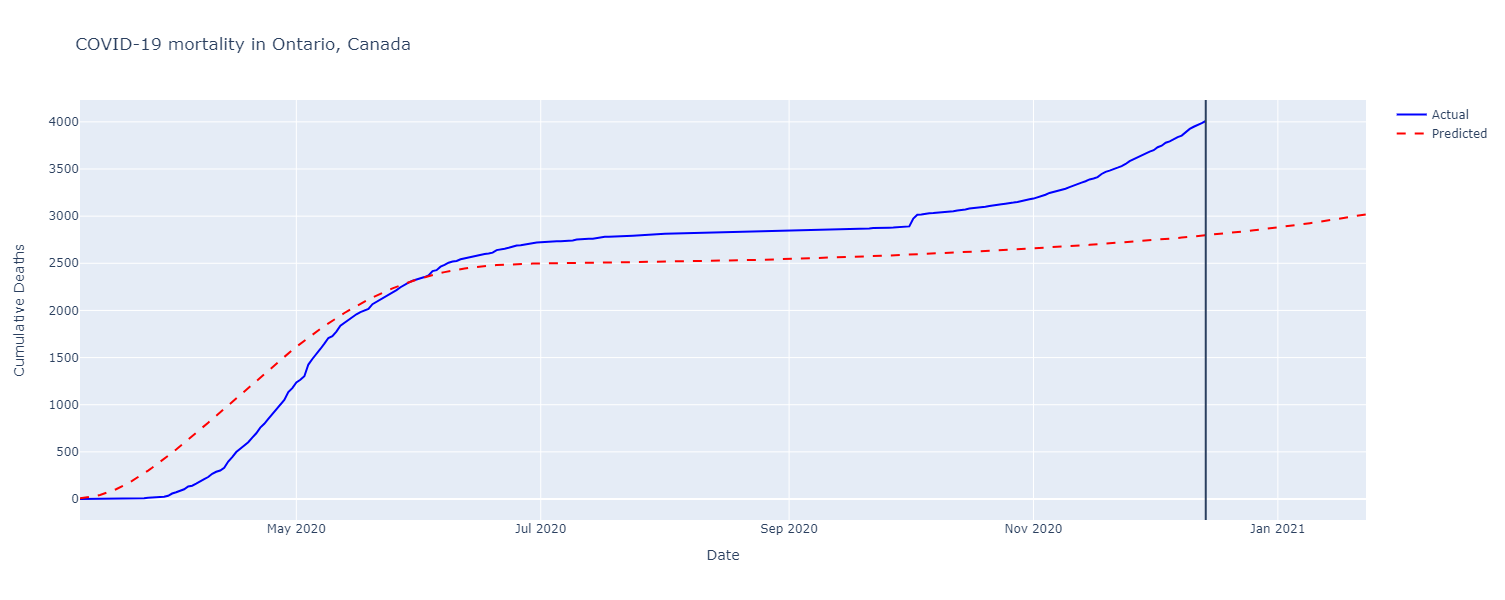

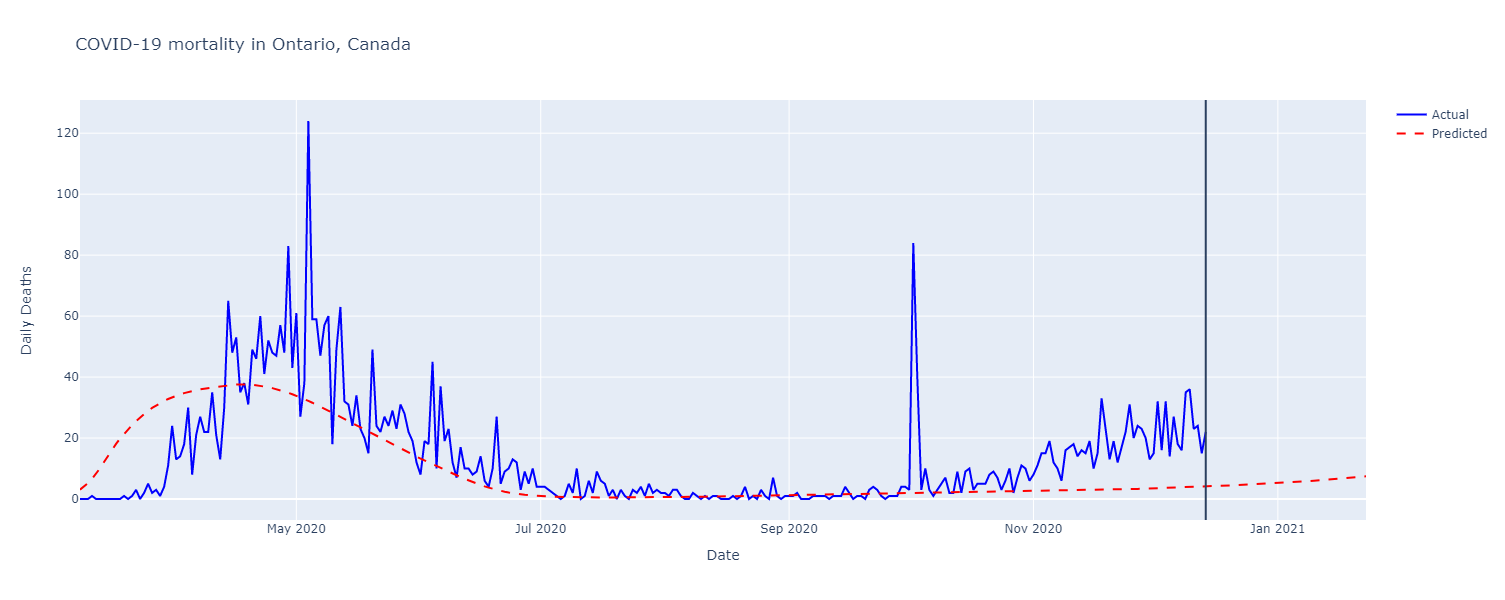

In [12]:
# Plot results for cumulative deaths
plot_predictions(
    mortality_pred,
    y="cumulative_deaths",
    y_label="Cumulative Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

# Plot results for daily deaths
plot_predictions(
    mortality_pred,
    y="deaths",
    y_label="Daily Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

In [13]:
mortality_pred

,date,infections_pred,hospitalizations_pred,cumulative_deaths_pred,deaths_pred,province,cumulative_cases,cumulative_recovered,cumulative_deaths,active_cases,active_cases_change,deaths,recovered,cases,population,removed,cumulative_removed,susceptible,percent_susceptible,is_forecast
0,2020-03-08,852.894052,175.0,8.914842,3.067881,Ontario,32.0,4.0,0.0,28.0,4.0,0.0,0.0,4.0,14734014.0,0.0,4.0,14733982.0,0.999998,False
1,2020-03-09,842.215507,194.0,12.986998,4.072156,Ontario,35.0,5.0,0.0,30.0,2.0,0.0,1.0,3.0,14734014.0,1.0,5.0,14733979.0,0.999998,False
2,2020-03-10,831.531716,196.0,18.221095,5.234096,Ontario,37.0,5.0,0.0,32.0,2.0,0.0,0.0,2.0,14734014.0,0.0,5.0,14733977.0,0.999997,False
3,2020-03-11,820.871514,198.0,24.802578,6.581483,Ontario,42.0,5.0,1.0,36.0,4.0,1.0,0.0,5.0,14734014.0,1.0,6.0,14733972.0,0.999997,False
4,2020-03-12,810.256516,199.0,33.006927,8.204349,Ontario,59.0,5.0,1.0,53.0,17.0,0.0,0.0,17.0,14734014.0,0.0,6.0,14733955.0,0.999996,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,2021-01-19,611.366334,96.0,2989.687327,6.948040,Ontario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
318,2021-01-20,623.701554,97.0,2996.751451,7.064123,Ontario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
319,2021-01-21,636.372767,99.0,3003.934415,7.182964,Ontario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
320,2021-01-22,649.390824,101.0,3011.239057,7.304643,Ontario,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


#### Cross validation scores

In [14]:
%%time

tscv = TimeSeriesSplit(n_splits=10)

# loop through each province and each split
for province in provinces:
    mortality_province = mortality_provinces.query('province == @province')
    region_model = region_models[province]
    
    for index, (train_index, test_index) in enumerate(tscv.split(mortality_province)):
        mortality_train = mortality_province.iloc[train_index]
        mortality_test = mortality_province.iloc[test_index]

        # Fit model to train set
        optimizer = BayesianOptimization(
            f=lambda initial_r_0, lockdown_r_0, mortality_rate, daily_imports: -loss(
                (initial_r_0, lockdown_r_0, mortality_rate, daily_imports),
                params_dict.copy(),
                region_model,
                mortality_province,
            ),
            pbounds=pbounds,
            verbose=0,
        )
        
        # Run optimization
        optimizer.maximize(
            init_points=100,
            n_iter=100,
        )

        # Initialize parameters for region_model using estimated params
        max_params = optimizer.max["params"]
        params = params_dict.copy()
        params["INITIAL_R_0"] = max_params["initial_r_0"]
        params["LOCKDOWN_R_0"] = max_params["lockdown_r_0"]
        params["MORTALITY_RATE"] = max_params["mortality_rate"]
        params["DAILY_IMPORTS"] = max_params["daily_imports"]

        params_tups = tuple(params.items())
        region_model.init_params(params_tups)

        # Run simulation and calculate loss
        mortality_pred = predict(region_model, mortality_train)
        mortality_pred = mortality_pred.iloc[test_index]

        rmse = mean_squared_error(mortality_test['cumulative_deaths'], mortality_pred['cumulative_deaths_pred'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'bayesian_opt', 'fold': index, 'rmse': rmse}, ignore_index=True)
        
    print(f'Completed {province}')
        
# Save results
cv_scores.to_csv("../models/seir_cross_val_scores.csv", index=False)

Completed Alberta
Completed BC
Completed Manitoba
Completed Ontario
Completed Quebec
Completed Saskatchewan
Wall time: 41min 35s


In [15]:
# Average rmse scores
cv_scores.query('method == "bayesian_opt"').groupby("province").agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province         rmse                                      
                        mean          std         min          max
0       Alberta  3046.274942  3829.441605   15.945460  8850.879769
1            BC  2207.296228  3244.924781   11.866698  9570.223648
2      Manitoba  1592.250059  1141.390190   24.702715  2820.964891
3       Ontario   542.621948   624.131748    8.249435  1743.103537
4        Quebec  1709.022510  1662.952963  354.929897  5134.181958
5  Saskatchewan   728.476174  1006.323091    1.097892  2260.655395

### Grid search

Similar to the original ygg implementation we will apply a simple grid search in combination with cross validation to estimate the model parameters.

In [16]:
def estimate_params_grid(
    params_dict: dict,
    region_model,
    mortality_data: pd.DataFrame,
) -> dict:

    # Create grid of model parameters
    param_grid = {
        "INITIAL_R_0": np.linspace(0.5, 2, num=10),
        "LOCKDOWN_R_0": np.linspace(0.5, 2, num=10),
        "MORTALITY_RATE": np.geomspace(1e-4, 0.2, num=10, endpoint=False),
        "DAILY_IMPORTS": np.linspace(0, 250, num=10),
    }
    param_list = list(ParameterGrid(param_grid))

    # Run model with each set of parameters and keep track of best one
    best_rmse = np.Inf
    best_params = None

    for param in param_list:
        variable_params = (
            param["INITIAL_R_0"],
            param["LOCKDOWN_R_0"],
            param["MORTALITY_RATE"],
            param["DAILY_IMPORTS"],
        )
        rmse = loss(variable_params, params_dict.copy(), region_model, mortality_data)
        if rmse < best_rmse:
            best_rmse = rmse
            best_param = param

    return best_rmse, best_param

In [17]:
# Estimate parameters on train set
rmse, params = estimate_params_grid(
    params_dict.copy(), region_models["Ontario"], mortality_ontario
)

# Initialize parameters for region model using estimated params
params_tups = tuple({**params_dict.copy(), **params}.items())
region_models["Ontario"].init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_models["Ontario"], mortality_ontario)
print(f"rmse: {rmse}")

rmse: 177.86711652115346


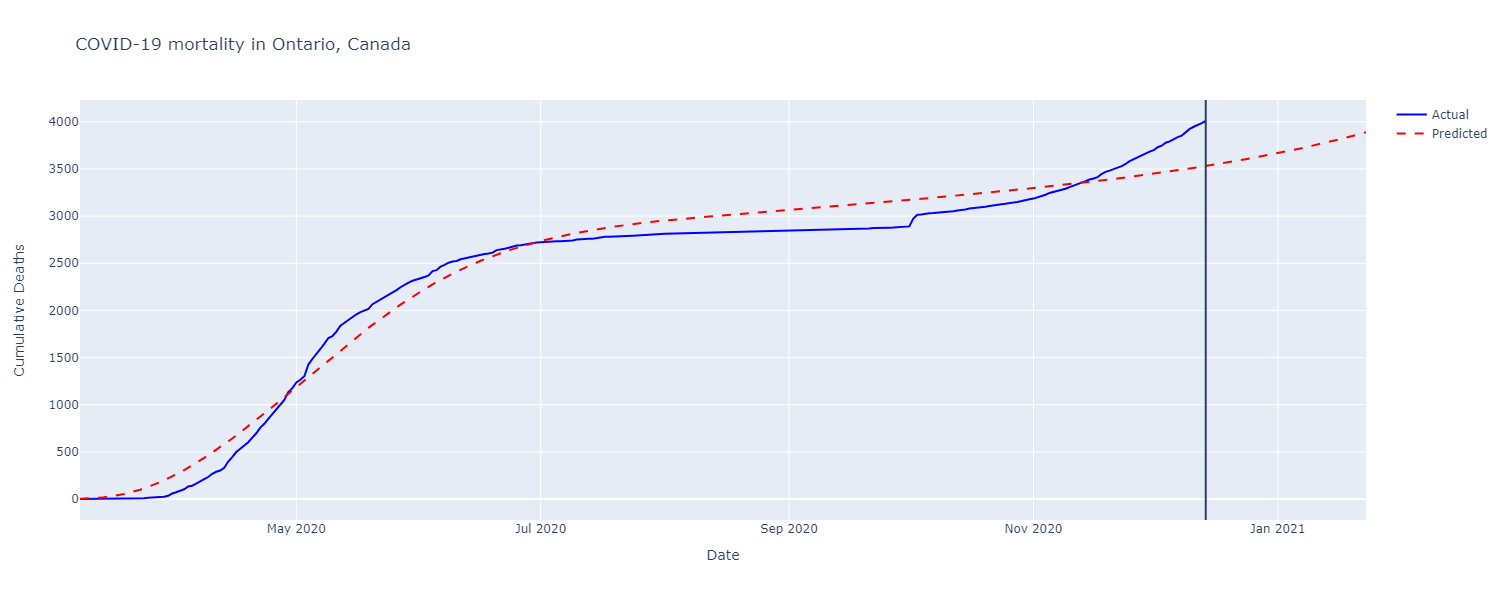

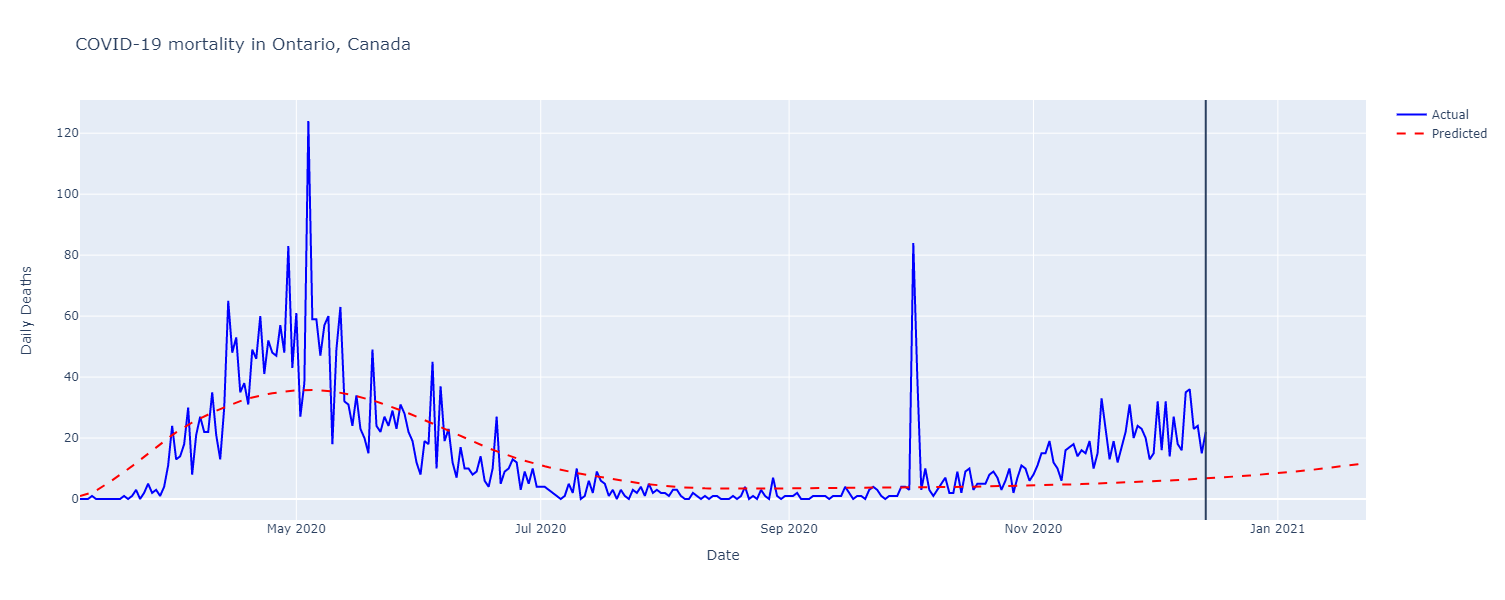

In [18]:
# Plot results for cumulative deaths
plot_predictions(
    mortality_pred,
    y="cumulative_deaths",
    y_label="Cumulative Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

# Plot results for daily deaths
plot_predictions(
    mortality_pred,
    y="deaths",
    y_label="Daily Deaths",
    title="COVID-19 mortality in Ontario, Canada",
    height=600,
)

#### Cross validation scores

In [19]:
%%time

tcsv = TimeSeriesSplit(n_splits=10)

# Loop through each province and each split, and also each set of parameters in the grid
for province in provinces:
    mortality_province = mortality_provinces.query('province == @province')
    region_model = region_models[province]
    
    for index, (train_index, test_index) in enumerate(tcsv.split(mortality_province)):
        mortality_train = mortality_province.iloc[train_index]
        mortality_test = mortality_province.iloc[test_index]

        # Estimate parameters on train set
        rmse, params = estimate_params_grid(params_dict.copy(), region_model, mortality_train)
        
        # Initialize parameters for region model using estimated params
        params_tups = tuple({**params_dict.copy(), **params}.items())
        region_model.init_params(params_tups)

        # Run simulation and calculate loss
        mortality_pred = predict(region_model, mortality_train)
        mortality_pred = mortality_pred.iloc[test_index]

        rmse = mean_squared_error(mortality_test['cumulative_deaths'], mortality_pred['cumulative_deaths_pred'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'grid_search', 'fold': index, 'rmse': rmse}, ignore_index=True)
        
    print(f'Completed {province}')
    
# Save results
cv_scores.to_csv("../models/seir_cross_val_scores.csv", index=False)

Completed Alberta
Completed BC
Completed Manitoba
Completed Ontario
Completed Quebec
Completed Saskatchewan
Wall time: 3h 52min 46s


In [20]:
# Average rmse scores
cv_scores.query('method == "grid_search"').groupby(["province", "method"]).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province       method        rmse                                     
                                    mean         std         min          max
0       Alberta  grid_search   62.553738   74.336530    5.592037   255.465128
1            BC  grid_search   35.531723   57.995170    3.761773   192.892883
2      Manitoba  grid_search   45.267563   97.018868    0.401045   310.096627
3       Ontario  grid_search  475.252570  988.016082   39.522843  3220.467115
4        Quebec  grid_search  640.977884  415.283805  218.434736  1577.309676
5  Saskatchewan  grid_search    6.599075    9.593836    0.561408    33.167194

### Optimization method comparison

In [21]:
# Average rmse scores
cv_scores.groupby(["province", "method"]).agg(
    {"rmse": ["mean", "std", "min", "max"]}
).reset_index()

province        method         rmse                           \
                                       mean          std         min   
0        Alberta  bayesian_opt  3046.274942  3829.441605   15.945460   
1        Alberta   grid_search    62.553738    74.336530    5.592037   
2        Alberta      l-bfgs-b    67.068382    74.641694    3.095179   
3             BC  bayesian_opt  2207.296228  3244.924781   11.866698   
4             BC   grid_search    35.531723    57.995170    3.761773   
5             BC      l-bfgs-b    42.972625    68.347878    4.009186   
6       Manitoba  bayesian_opt  1592.250059  1141.390190   24.702715   
7       Manitoba   grid_search    45.267563    97.018868    0.401045   
8       Manitoba      l-bfgs-b    42.975874    95.495017    0.433648   
9        Ontario  bayesian_opt   542.621948   624.131748    8.249435   
10       Ontario   grid_search   475.252570   988.016082   39.522843   
11       Ontario      l-bfgs-b   166.306716   190.000755    8.929944   
12        Quebec  bayesian_opt  1709.022510  1662.952963  354.929897   
13        Quebec   grid_search   640.977884   415.283805  218.434736   
14        Quebec      l-bfgs-b   464.740089   462.224221   18.464135   
15  Saskatchewan  bayesian_opt   728.476174  1006.323091    1.097892   
16  Saskatchewan   grid_search     6.599075     9.593836    0.561408   
17  Saskatchewan      l-bfgs-b     5.173732     8.862186    0.510396   

                 
            max  
0   8850.879769  
1    255.465128  
2    231.712604  
3   9570.223648  
4    192.892883  
5    232.534123  
6   2820.964891  
7    310.096627  
8    302.840296  
9   1743.103537  
10  3220.467115  
11   546.944723  
12  5134.181958  
13  1577.309676  
14  1415.426618  
15  2260.655395  
16    33.167194  
17    29.884383

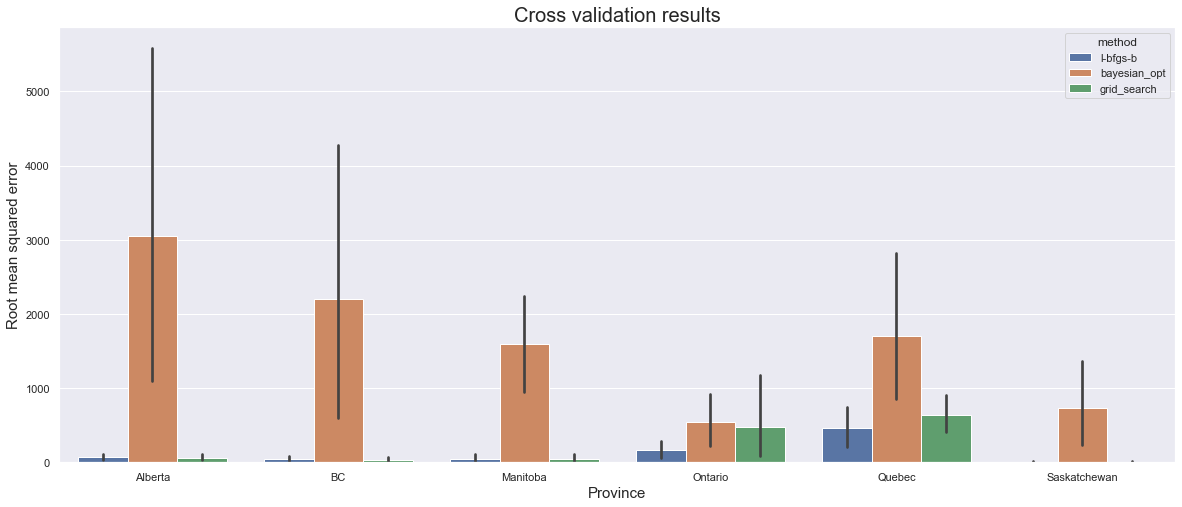

In [22]:
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="province", y="rmse", hue="method", data=cv_scores)
t = ax.set_title("Cross validation results", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

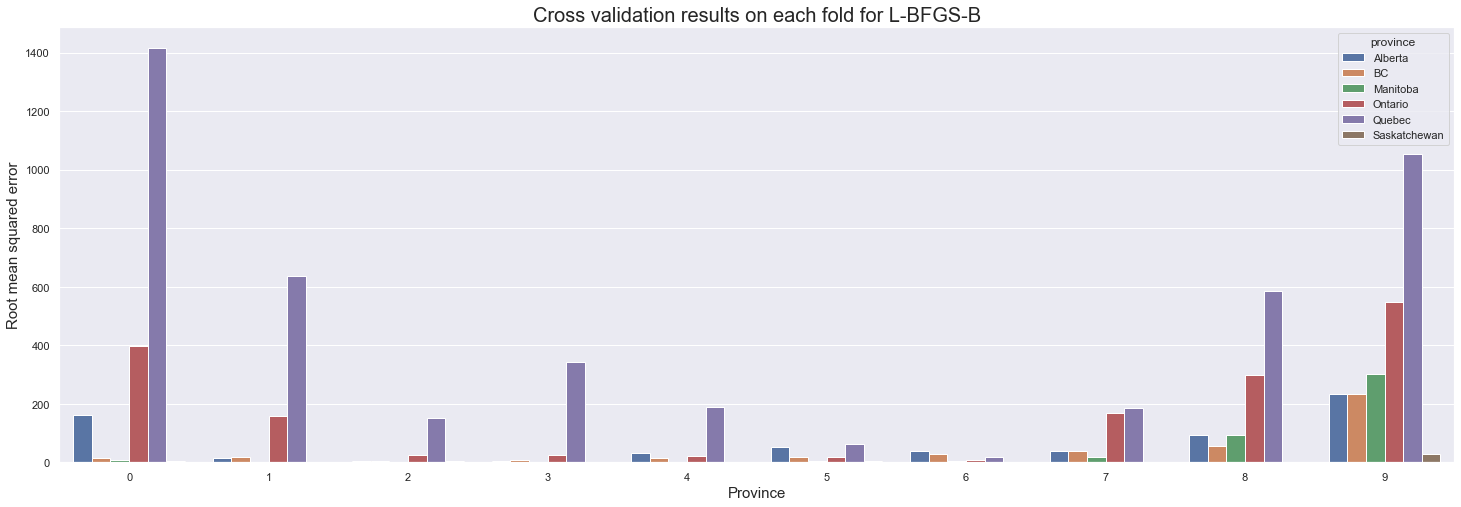

In [23]:
fig = plt.figure(figsize=(25, 8))
ax = sns.barplot(
    x="fold", y="rmse", hue="province", data=cv_scores.query('method == "l-bfgs-b"')
)
t = ax.set_title("Cross validation results on each fold for L-BFGS-B", fontsize=20)
t = ax.set_ylabel("Root mean squared error", fontsize=15)
t = ax.set_xlabel("Province", fontsize=15)

### Comments on SEIR Parameter Estimation

- The bounded constrained minimization using L-BFGS-B performs fairly well and is able to capture the pattern of the disease well. It also gives much lower cross validated mean rmse scores in comparison to the other two optimization algorithms.
- Bayesian optimization does not perform too well and clearly is missing the actual curve of cumulative deaths. As well, the variance in the bayesian optimization algorithm is much too high as two different runs on the same dataset can produce massively different results and so it is not stable. We will not be using this in our final model however no harm in testing it out.
- **Note** - Cross validation results are most likely overestimates of the true testing error as the errors from first few folds will likely be fairly high as there is data to fit the model on
- Quebec has fairly high rmse score on folds 4-5 which is most likely from the large spike in deaths in Quebec during May.

## Final model results

For our final model we'll be using SEIR parameter estimation with the L-BGFS-B algorithm.

In [24]:
# Fit model to all provinces

mortality_pred_provinces = pd.DataFrame()

# Estimate optimal parameters using L-BFGS-B method in scipy
x0 = [1, 1, 0.01, 100]
bounds = [(1e-4, 10), (1e-4, 10), (1e-4, 0.2 - 1e-6), (0, 1000)]

for province in provinces:
    region_model = region_models[province]
    mortality_province = mortality_provinces.query("province == @province")

    # Fit model to train set
    optimal = minimize(
        loss,
        x0=x0,
        args=(params_dict.copy(), region_model, mortality_province),
        method="L-BFGS-B",
        bounds=bounds,
    )

    # Initialize parameters
    params = params_dict.copy()
    (
        params["INITIAL_R_0"],
        params["LOCKDOWN_R_0"],
        params["MORTALITY_RATE"],
        params["DAILY_IMPORTS"],
    ) = optimal.x
    params_tups = tuple(params.items())
    region_model.init_params(params_tups)

    # Get predictions and append results
    mortality_pred = predict(region_model, mortality_province)
    mortality_pred_provinces = mortality_pred_provinces.append(
        mortality_pred, ignore_index=True
    )

In [25]:
params_dict

{'INFLECTION_DAY': datetime.date(2020, 3, 27),
 'RATE_OF_INFLECTION': 0.3497453946619491,
 'LOCKDOWN_FATIGUE': 1.0,
 'REOPEN_DATE': datetime.date(2020, 6, 1),
 'REOPEN_SHIFT_DAYS': 14.24962572681525,
 'REOPEN_R': 0.9350336996413784,
 'REOPEN_INFLECTION': 0.30222943084385256,
 'POST_REOPEN_EQUILIBRIUM_R': 0.9875365749849131,
 'FALL_R_MULTIPLIER': 1.0010158770538358}

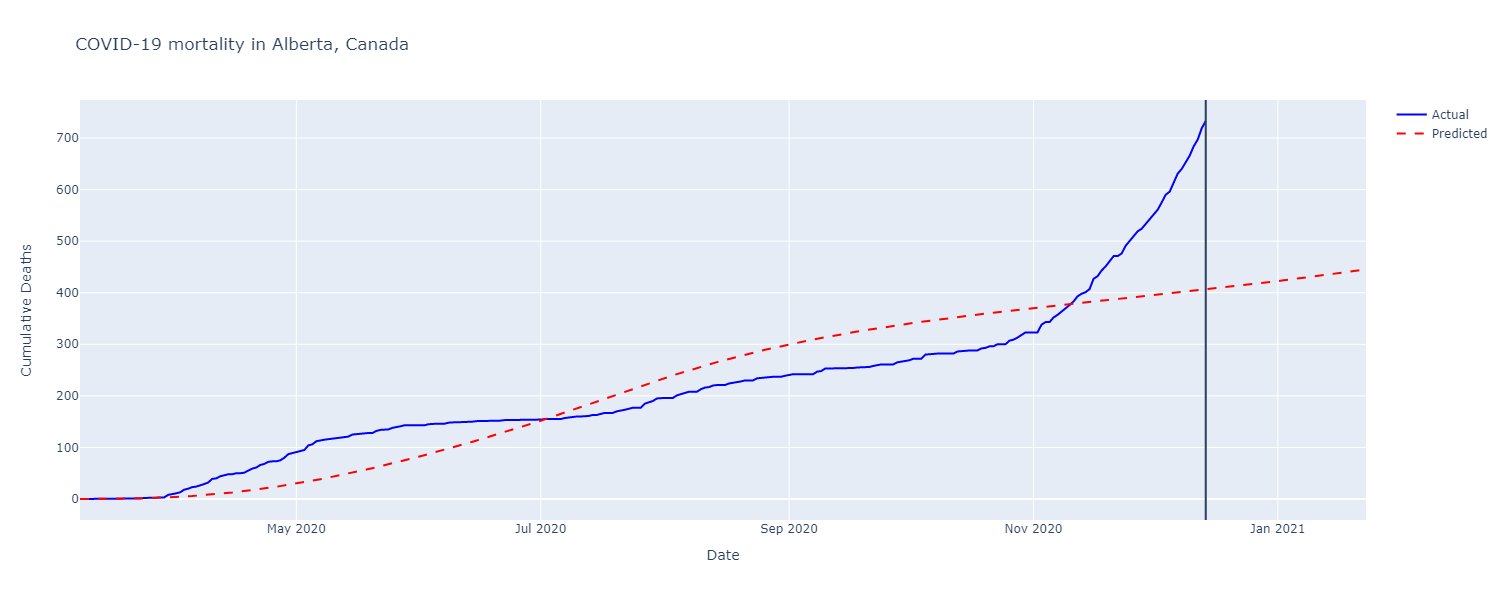

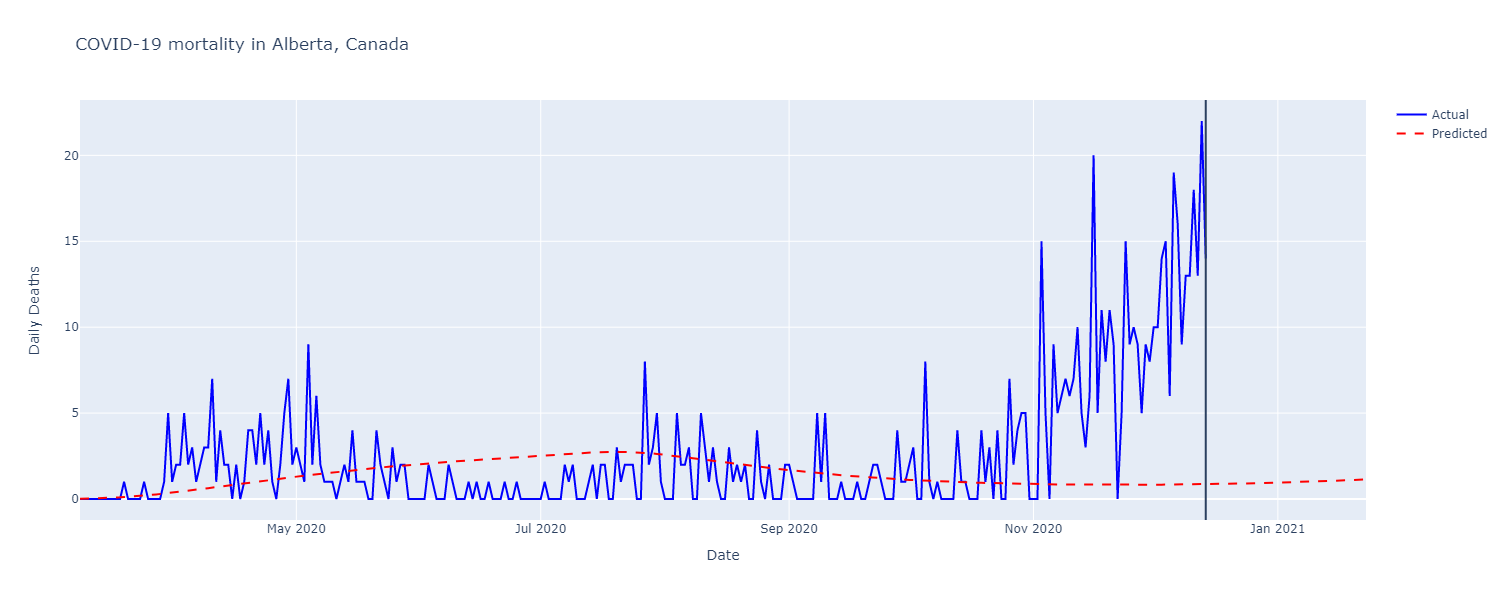

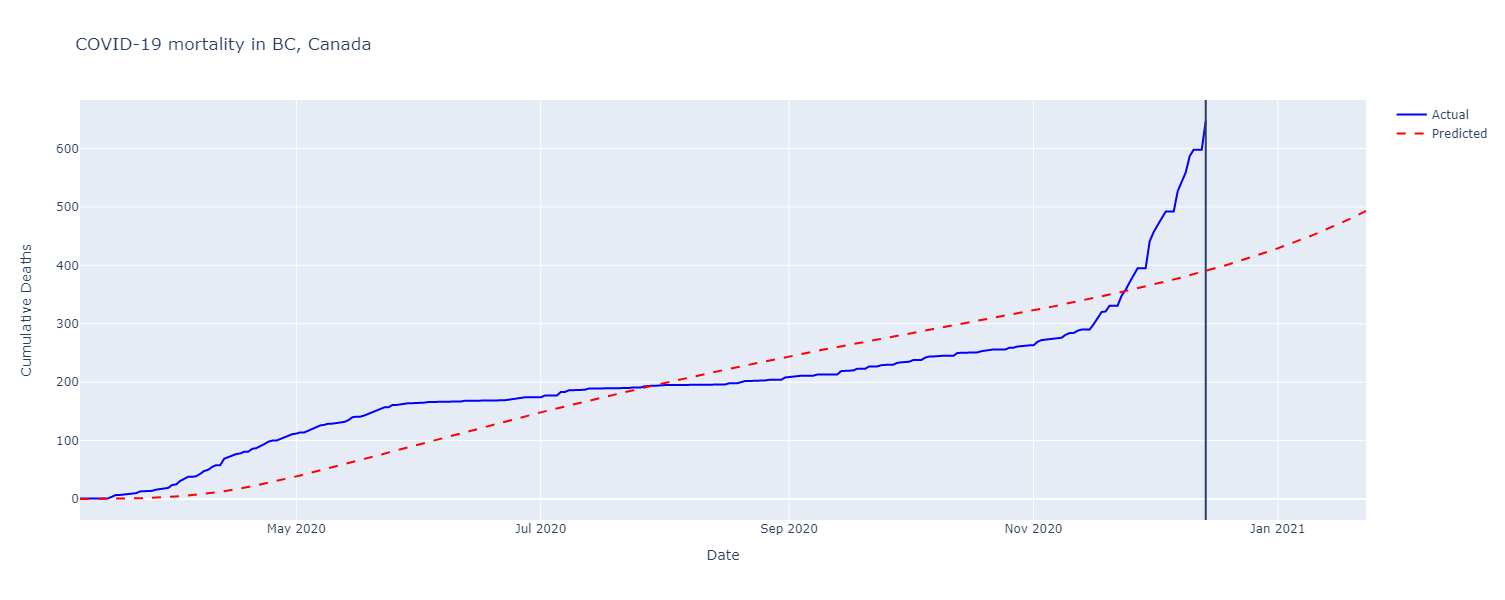

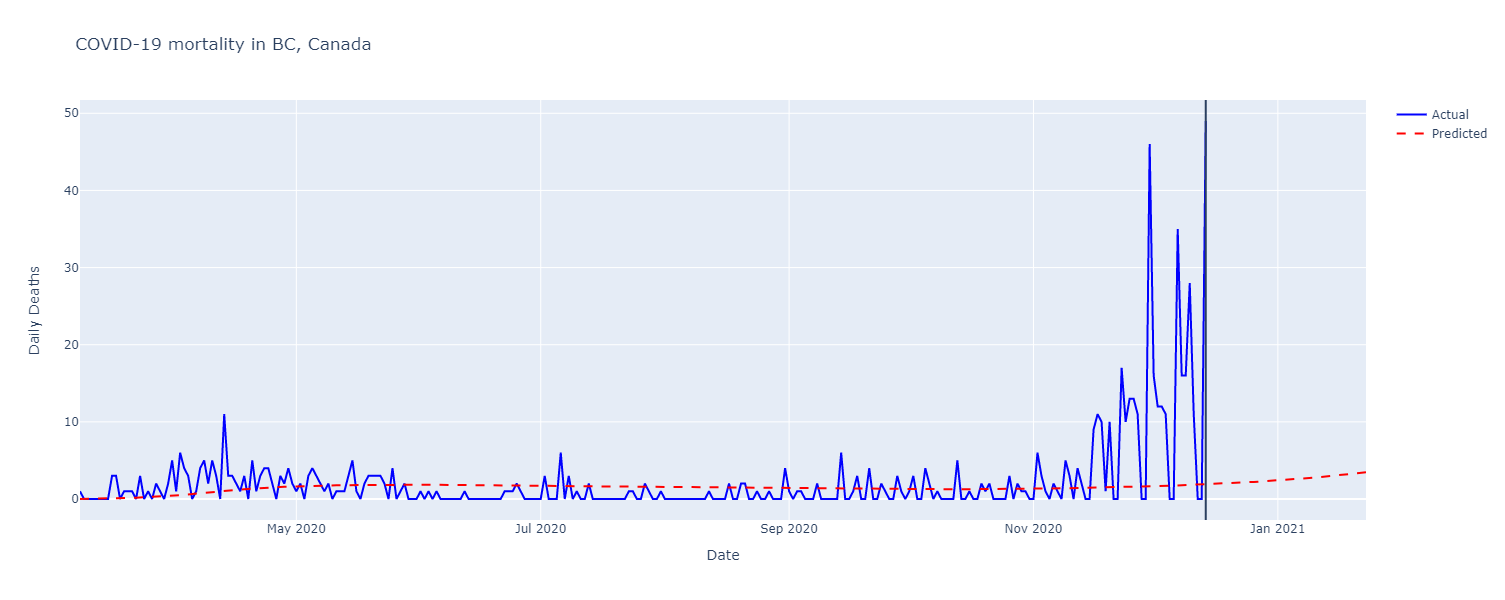

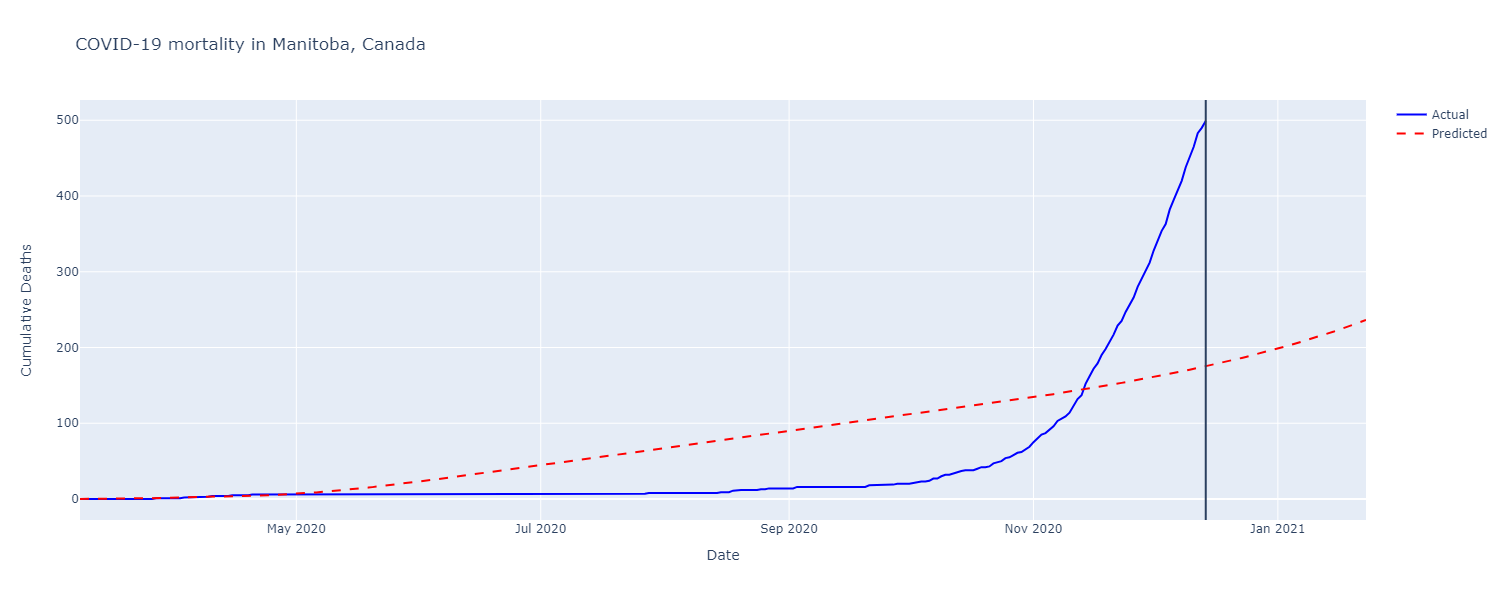

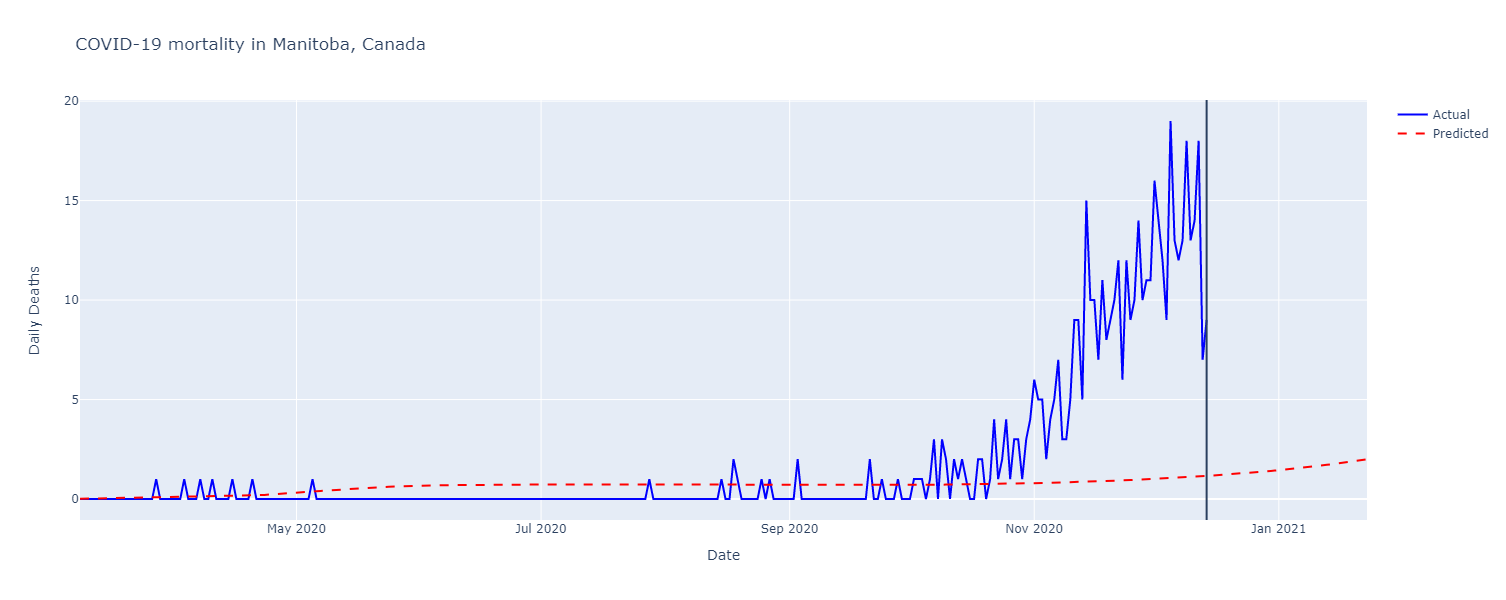

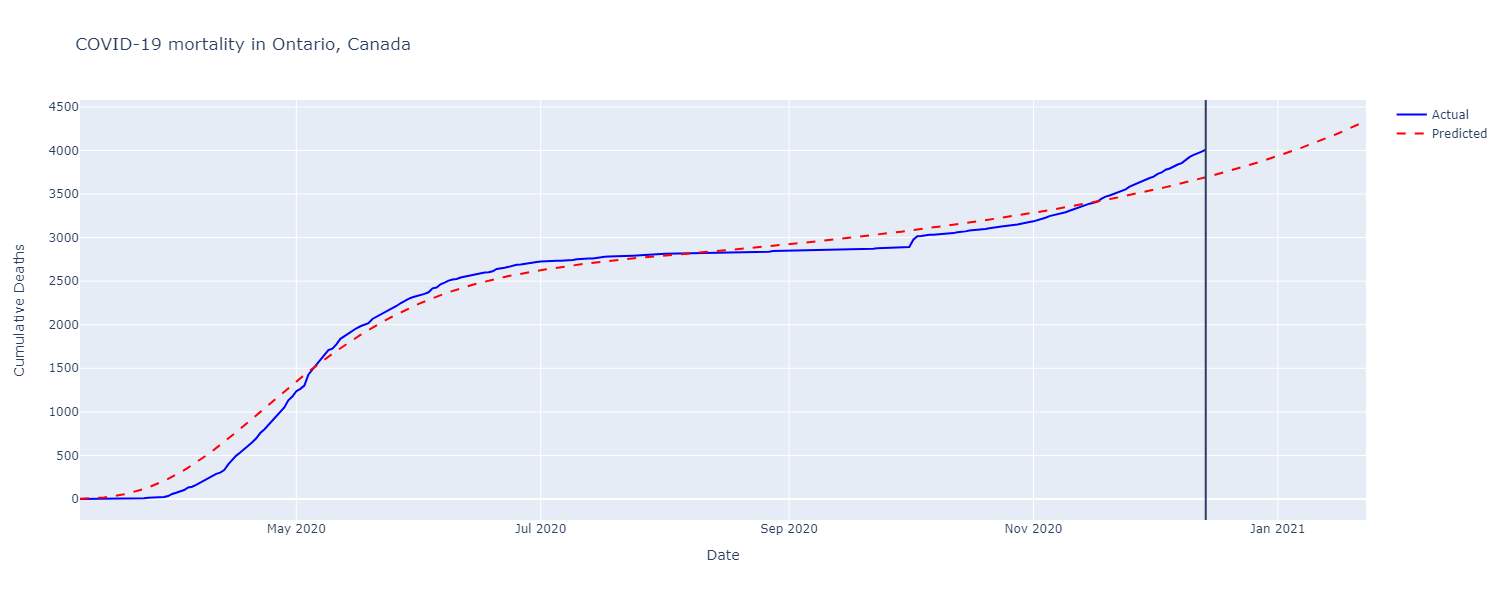

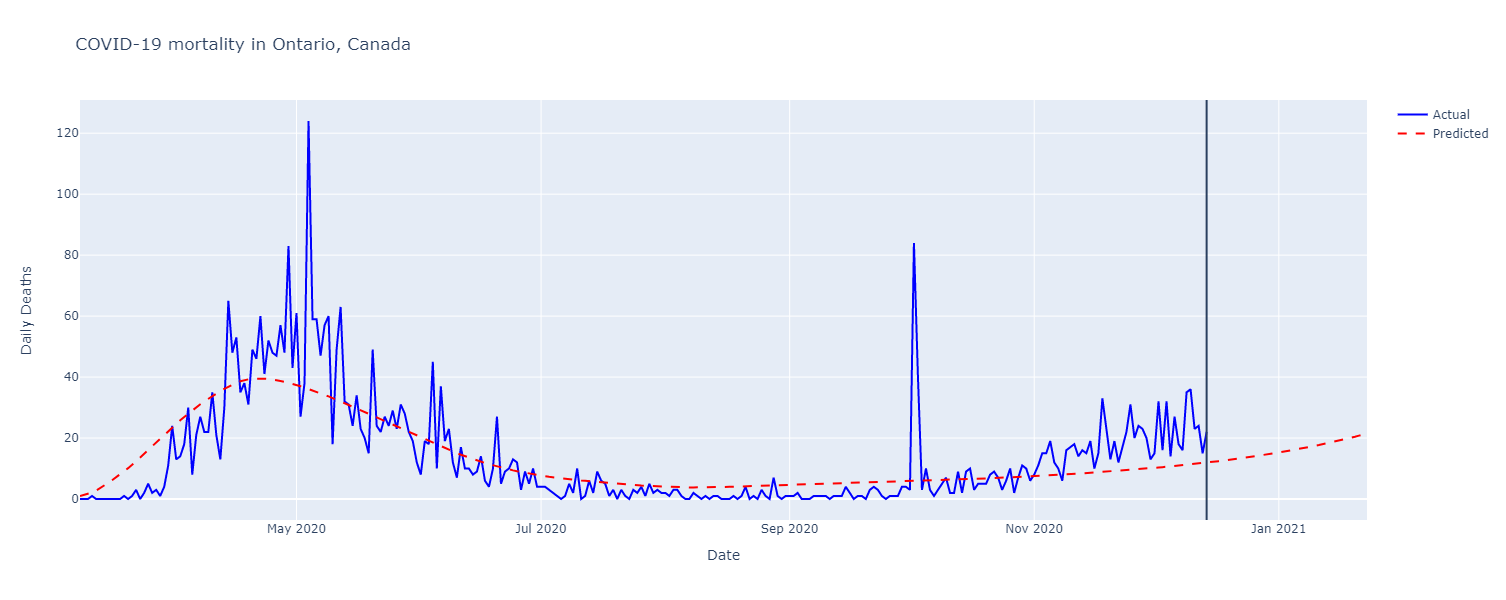

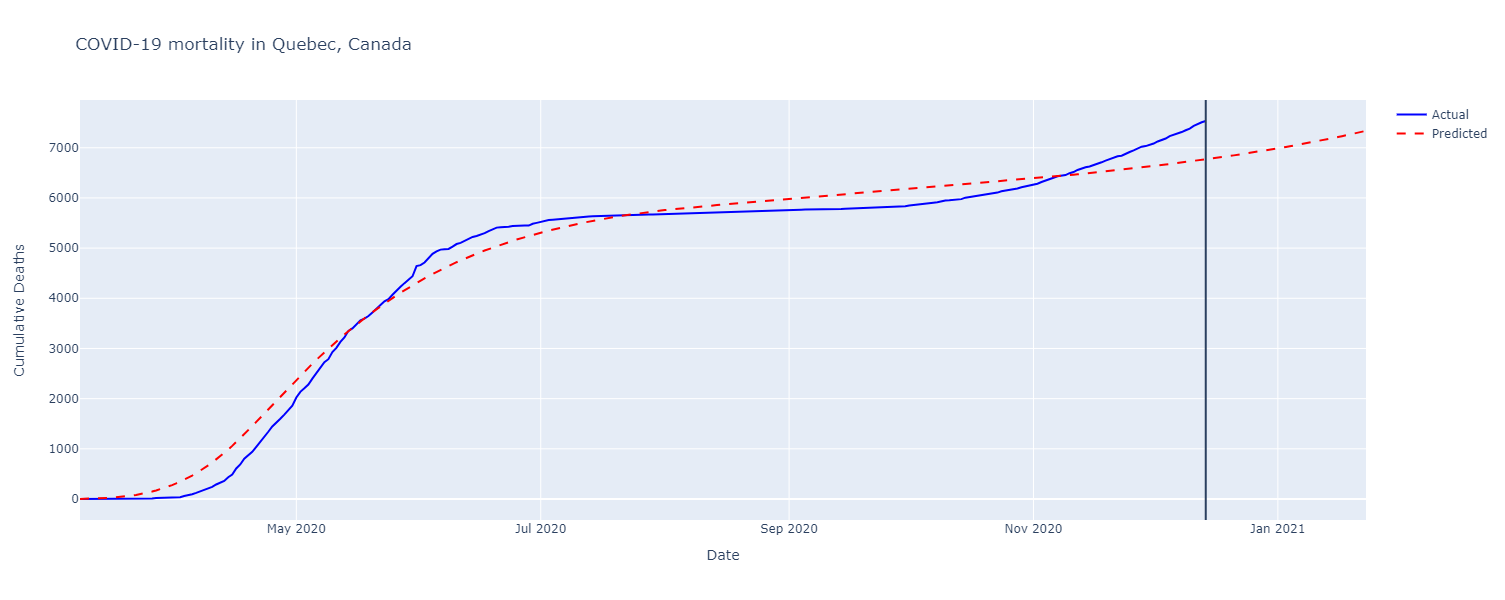

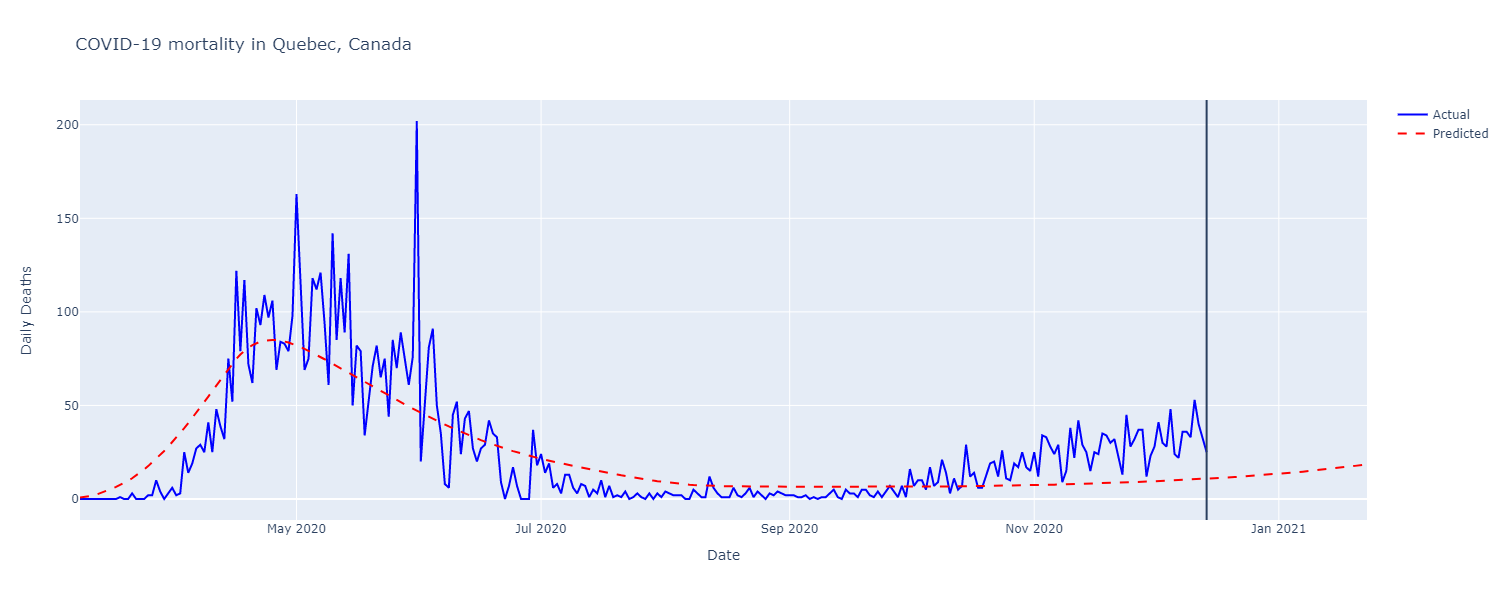

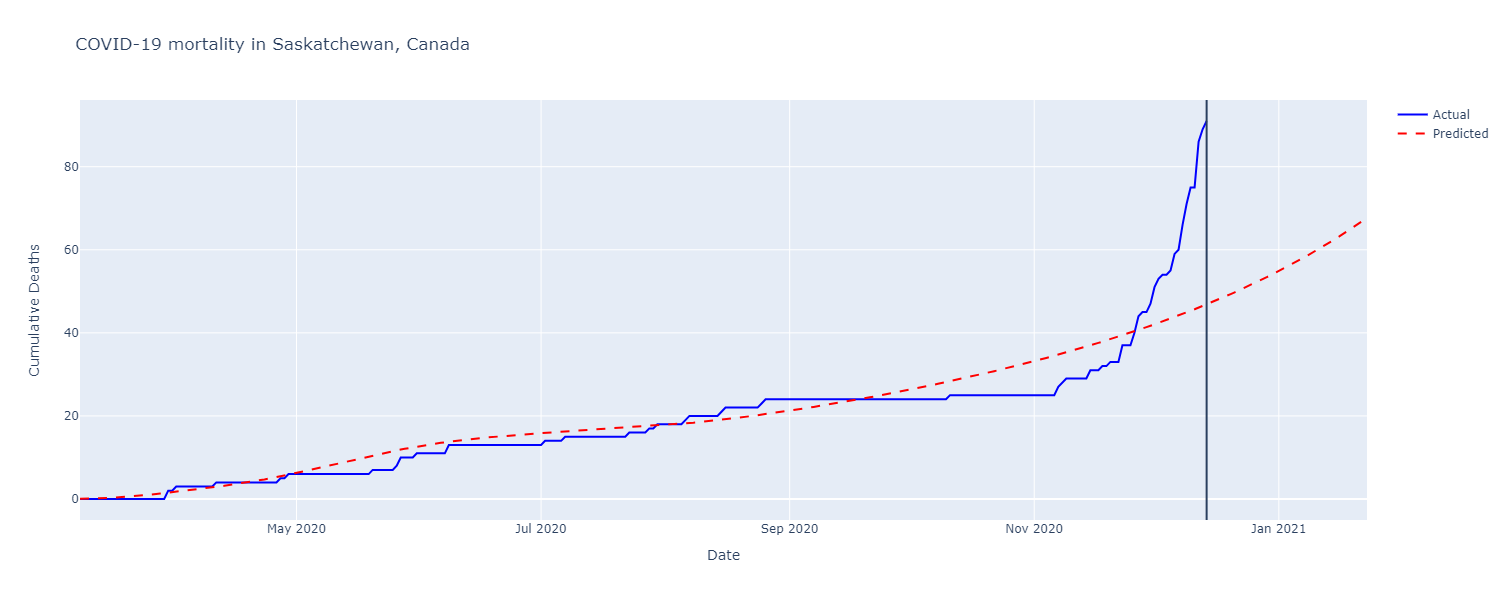

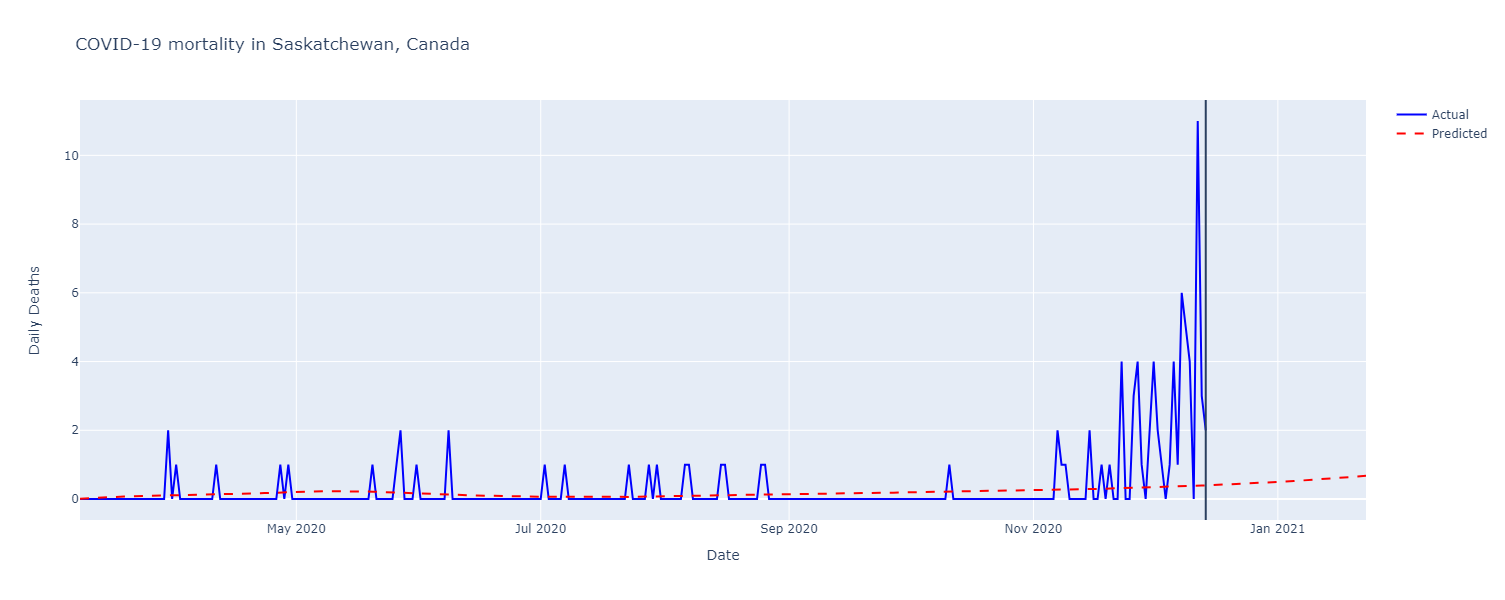

In [26]:
# Plot forecasts for all provinces
for province in provinces:
    mortality_pred = mortality_pred_provinces.query("province == @province")

    # Plot results for cumulative deaths
    plot_predictions(
        mortality_pred,
        y="cumulative_deaths",
        y_label="Cumulative Deaths",
        title=f"COVID-19 mortality in {province}, Canada",
        height=600,
    )

    # Plot results for daily deaths
    plot_predictions(
        mortality_pred,
        y="deaths",
        y_label="Daily Deaths",
        title=f"COVID-19 mortality in {province}, Canada",
        height=600,
    )

### Comments

- Most SEIR models seem to fit the actual curve fairly well up to October where there is an increased amount of daily deaths which the SEIR model isn't able to take it into account as the death/recovered compartment tends to level out. This is most likely due to the opening of Stage 3 which caused a spike in covid cases and leaded to going back to Stage 2. Similar to the Initial R_0 and Lockdown R_0 values, the assumption of constant R_0 value past social distancing does not seem too appropriate.
- Looking back at the mortality data for provinces it does not seem necessary to have model for Nova Scotia and Saskatchewan and possibly Manitoba as they don't have high cumulative deaths. This leaves only the 4 provinces Alberta, British Columbia, Ontario, and Quebec.